In [1]:
#importing necessary libraries
!pip install textstat rich -q

import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import nltk
import textstat
import time
import wandb
import rich
import spacy
import string

from pandas import DataFrame
from matplotlib.lines import Line2D
from rich.console import Console
from rich import print
from rich.theme import Theme
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

In [2]:
#Importing the training and testing dataset from Kaggle's IMDB Movie Genre Dataset

column_names = ['id','title','genre','description']
train_dataset = pd.read_csv('../input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt', sep=":::", names=column_names, index_col=0, header=None, engine='python')
test_dataset = pd.read_csv('../input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt', sep=":::", names=column_names, index_col=0, header=None, engine='python')

In [3]:
#understanding the dataset
train_dataset.info()
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54214 non-null  object
 1   genre        54214 non-null  object
 2   description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54200 entries, 1 to 54200
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54200 non-null  object
 1   genre        54200 non-null  object
 2   description  54200 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [4]:
#Finding total number of multi-class labels
generes = train_dataset['genre'].unique()
print("Target Generes\n",generes,"\n\nTotal Generes: ",len(generes))

Target Generes
 [' drama ' ' thriller ' ' adult ' ' documentary ' ' comedy ' ' crime '
 ' reality-tv ' ' horror ' ' sport ' ' animation ' ' action ' ' fantasy '
 ' short ' ' sci-fi ' ' music ' ' adventure ' ' talk-show ' ' western '
 ' family ' ' mystery ' ' history ' ' news ' ' biography ' ' romance '
 ' game-show ' ' musical ' ' war '] 

Total Generes:  27

In [5]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=3bbacea567ac663c426c2aacc2693b3dda23525eeeccd1c711adb29e6d6a1271
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [6]:
#detecting language of all the descriptions in training and testing datasets
from langdetect import detect, DetectorFactory
def detect_language(text):
    DetectorFactory.seed = 0
    lang = detect(text)
    return lang

In [7]:
train_dataset['language'] = train_dataset['description'].apply(detect_language)
test_dataset['language'] = test_dataset['description'].apply(detect_language)

In [8]:
#initial dataframes
train_dataset.info()
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54214 non-null  object
 1   genre        54214 non-null  object
 2   description  54214 non-null  object
 3   language     54214 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54200 entries, 1 to 54200
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54200 non-null  object
 1   genre        54200 non-null  object
 2   description  54200 non-null  object
 3   language     54200 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [9]:
#Dropping rows if language is non english
en_training_dataset = train_dataset.drop(train_dataset[train_dataset.language != 'en'].index)
en_testing_dataset = test_dataset.drop(test_dataset[test_dataset.language != 'en'].index)

In [10]:
#updated dataframes
en_training_dataset.info()
en_testing_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53842 entries, 1 to 54214
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        53842 non-null  object
 1   genre        53842 non-null  object
 2   description  53842 non-null  object
 3   language     53842 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 53814 entries, 1 to 54200
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        53814 non-null  object
 1   genre        53814 non-null  object
 2   description  53814 non-null  object
 3   language     53814 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


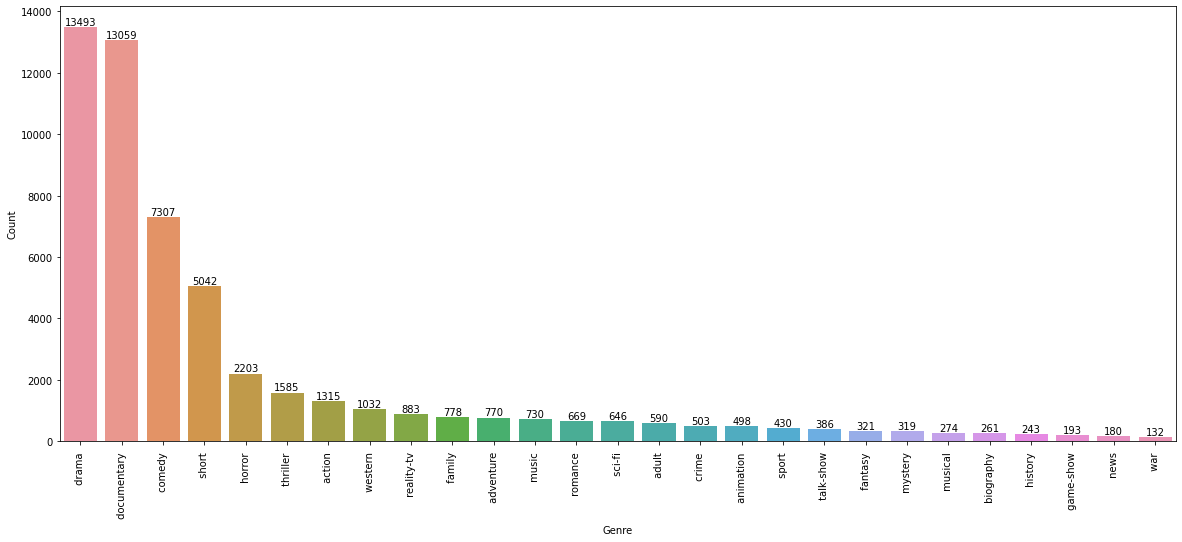

In [11]:
#Plot to show the genre distribution across the training dataset
plt.figure(figsize=(20,8))
counts = en_training_dataset.genre.value_counts()
ax = sns.barplot(x=counts.index, y=counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90);
ax.bar_label(ax.containers[0]);

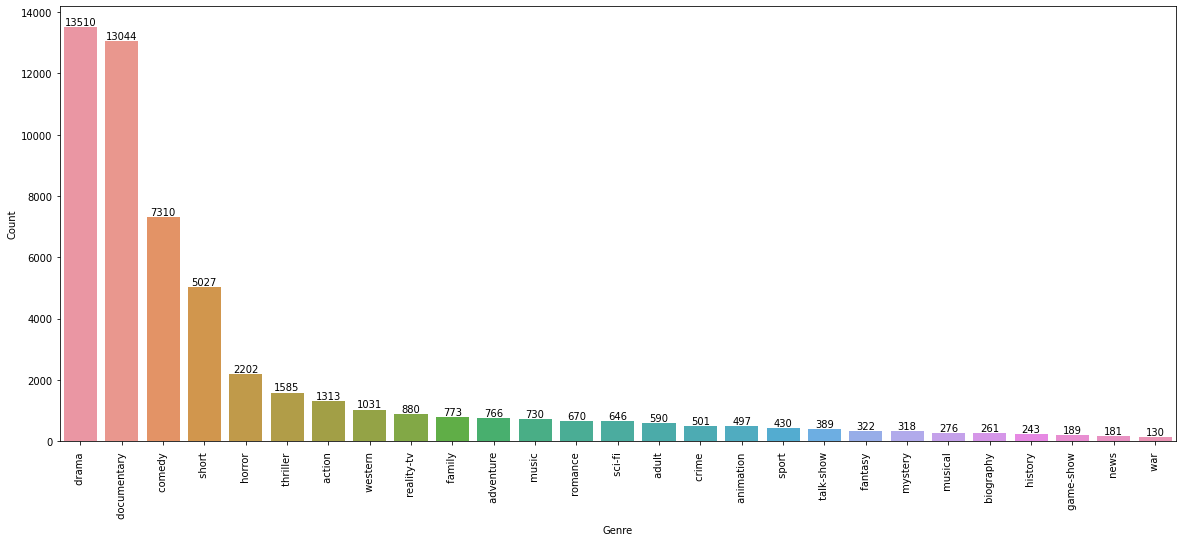

In [12]:
#Plot to show the genre distribution across the testing dataset
plt.figure(figsize=(20,8))
counts = en_testing_dataset.genre.value_counts()
ax = sns.barplot(x=counts.index, y=counts)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=90);
ax.bar_label(ax.containers[0]);

<AxesSubplot:ylabel='Frequency'>

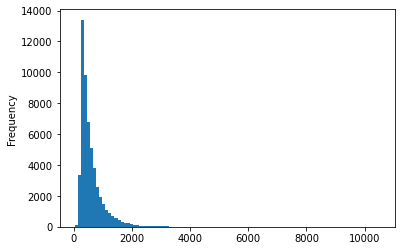

In [13]:
#Histogram that displays length distribution
train_dataset['length']=en_training_dataset['description'].apply(len)
train_dataset['length'].plot(bins=100, kind='hist')

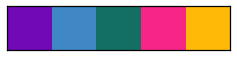

In [14]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

def custom_palette(custom_colors):
    customPalette = sns.set_palette(sns.color_palette(custom_colors))
    sns.palplot(sns.color_palette(custom_colors),size=0.8)
    plt.tick_params(axis='both', labelsize=0, length = 0)

palette = ["#7209B7","#3F88C5","#136F63","#F72585","#FFBA08"]
palette2 = sns.diverging_palette(120, 220, n=20)
custom_palette(palette)

custom_theme = Theme({
    "info" : "italic bold cyan",
    "warning": "italic bold magenta",
    "danger": "bold blue"
})

console = Console(theme=custom_theme)

In [15]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [16]:
def plot_wb_bar(df,col1,col2,name,title): 
    run = wandb.init(project='Movie Genre Classification', job_type='image-visualization',name=name)
    
    dt = [[label, val] for (label, val) in zip(df[col1], df[col2])]
    table = wandb.Table(data=dt, columns = [col1,col2])
    wandb.log({name : wandb.plot.bar(table, col1,col2,title=title)})

    run.finish()
    
#====== Function to plot wandb histogram ======
def plot_wb_hist(df,name,title):
    run = wandb.init(project='Movie Genre Classification', job_type='image-visualization',name=name)

    dt = [[x] for x in df[name]]
    table = wandb.Table(data=dt, columns=[name])
    wandb.log({name : wandb.plot.histogram(table, name, title=title)})

    run.finish()

In [17]:
def get_top_n_words(corpus, n=None):
    vec = CV().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CV(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CV(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [18]:
def plot_bt(x,w,p):
    common_words = x(en_training_dataset['description'], 20)
    common_words_df = DataFrame (common_words,columns=['word','freq'])

    plt.figure(figsize=(16,8))
    sns.barplot(x='freq', y='word', data=common_words_df,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette(p,20))
    plt.title("Top 20 "+ w,font='Serif')
    plt.xlabel("Frequency", fontsize=14)
    plt.yticks(fontsize=13)
    plt.xticks(rotation=45, fontsize=13)
    plt.ylabel("");
    return common_words_df


In [19]:
#Code to clean the text/ preprocessing in order to make it ready for consumption by language models
def clean_text(text):
    text = text.lower()                                  # lower-case all characters
    text =  re.sub(r'@\S+', '',text)                     # remove twitter handles
    text =  re.sub(r'http\S+', '',text)                  # remove urls
    text =  re.sub(r'pic.\S+', '',text) 
    text =  re.sub(r"[^a-zA-Z+']", ' ',text)             # only keeps characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ')      # keep words with length>1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    text= re.sub("\s[\s]+", " ",text).strip()            # remove repeated/leading/trailing spaces
    return text

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
#Applying the above clean_text method for cleaning and preprocessing the Description column of the dataset that is being subjected to the model
en_training_dataset['clean_description'] = en_training_dataset['description'].apply(clean_text)
en_testing_dataset['clean_description'] = en_testing_dataset['description'].apply(clean_text)

In [23]:
en_training_dataset['length'] = en_training_dataset['description'].apply(len)
en_training_dataset['length_cleaning']=en_training_dataset['clean_description'].apply(len)
en_training_dataset.head()

title       genre  \
id                                                   
1        Oscar et la dame rose (2009)       drama    
2                        Cupid (1997)    thriller    
3    Young, Wild and Wonderful (1980)       adult    
4               The Secret Sin (1915)       drama    
5              The Unrecovered (2007)       drama    

                                          description language  \
id                                                               
1    Listening in to a conversation between his do...       en   
2    A brother and sister with a past incestuous r...       en   
3    As the bus empties the students for their fie...       en   
4    To help their unemployed father make ends mee...       en   
5    The film's title refers not only to the un-re...       en   

                                    clean_description  length  length_cleaning  
id                                                                              
1   listening conversation doctor parents year old...     546              383  
2   brother sister past incestuous relationship cu...     184              119  
3   bus empties students field trip museum natural...     650              402  
4   help unemployed father make ends meet edith tw...    1082              745  
5   films title refers recovered bodies ground zer...     625              402

In [24]:
print("Average Length Before Text Cleaning: ", en_training_dataset['length'].mean())
print("Average Length After Text Cleaning: ", en_training_dataset['length_cleaning'].mean())

Average Length Before Text Cleaning:  600.2467776085583

Average Length After Text Cleaning:  408.238605549571

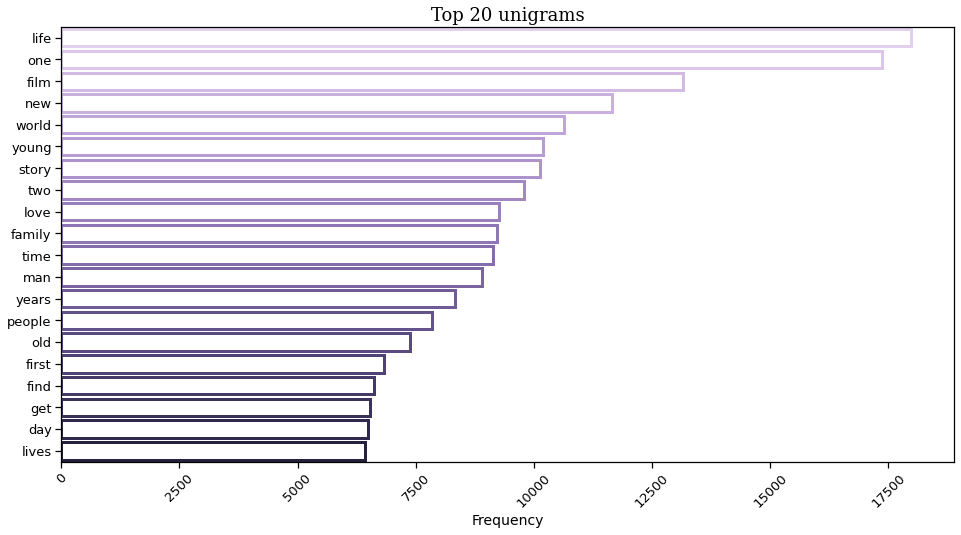

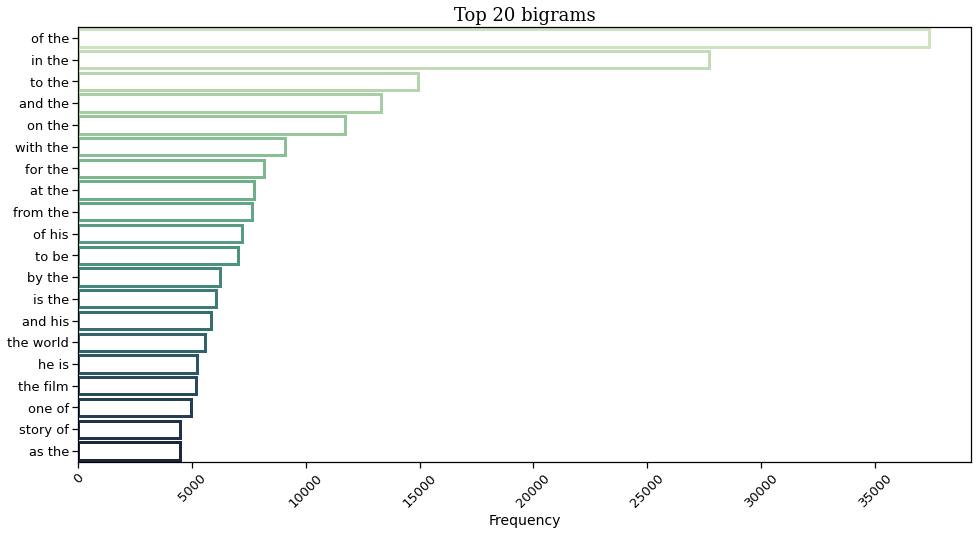

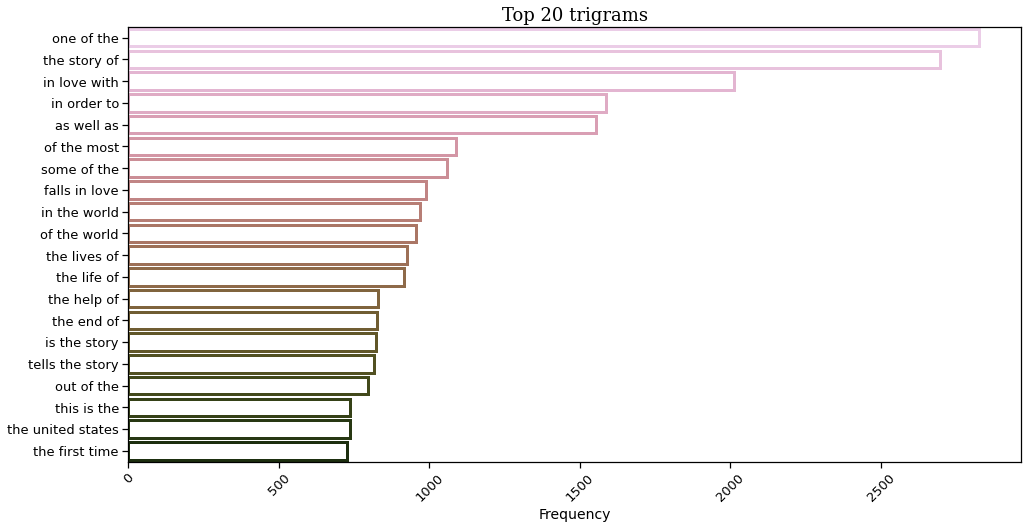

In [25]:
common_words = get_top_n_words(en_training_dataset['clean_description'], 20)
common_words_df1 = DataFrame(common_words,columns=['word','freq'])
plt.figure(figsize=(16, 8))
ax = sns.barplot(x='freq', y='word', data=common_words_df1,facecolor=(0, 0, 0, 0),linewidth=3,edgecolor=sns.color_palette("ch:start=3, rot=.1",20))

plt.title("Top 20 unigrams",font='Serif')
plt.xlabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.ylabel("");

common_words_df2 = plot_bt(get_top_n_bigram,"bigrams","ch:rot=-.5")
common_words_df3 = plot_bt(get_top_n_trigram,"trigrams","ch:start=-1, rot=-.6")

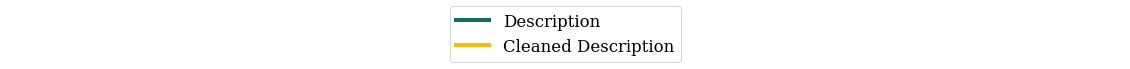

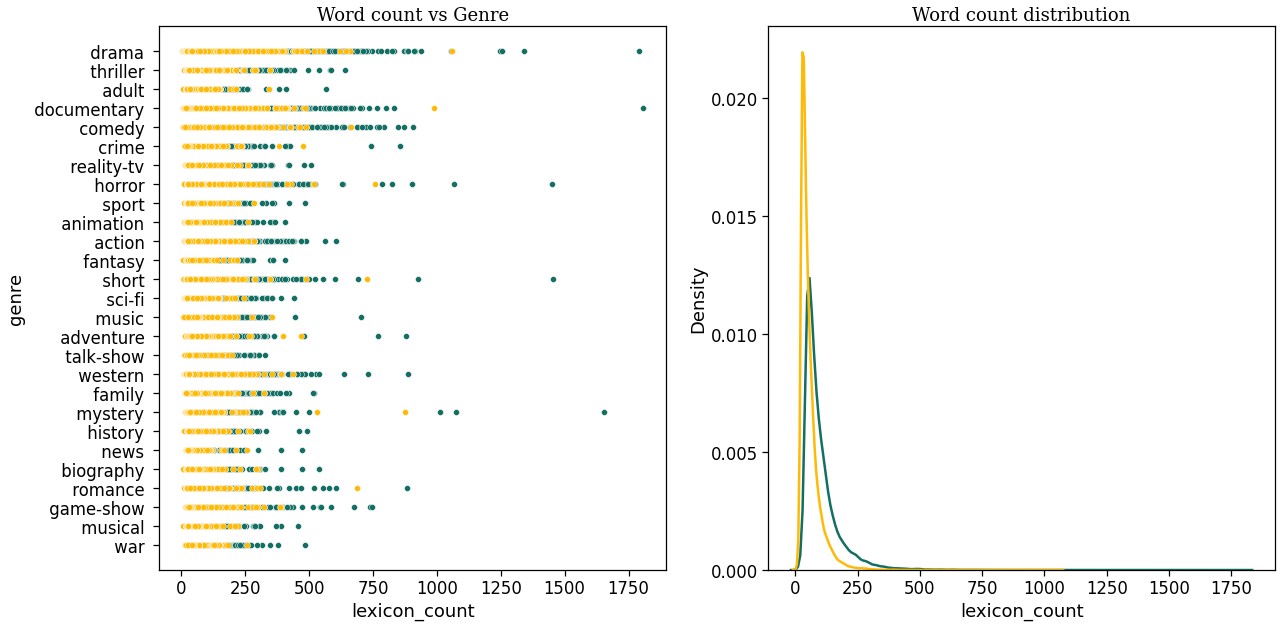

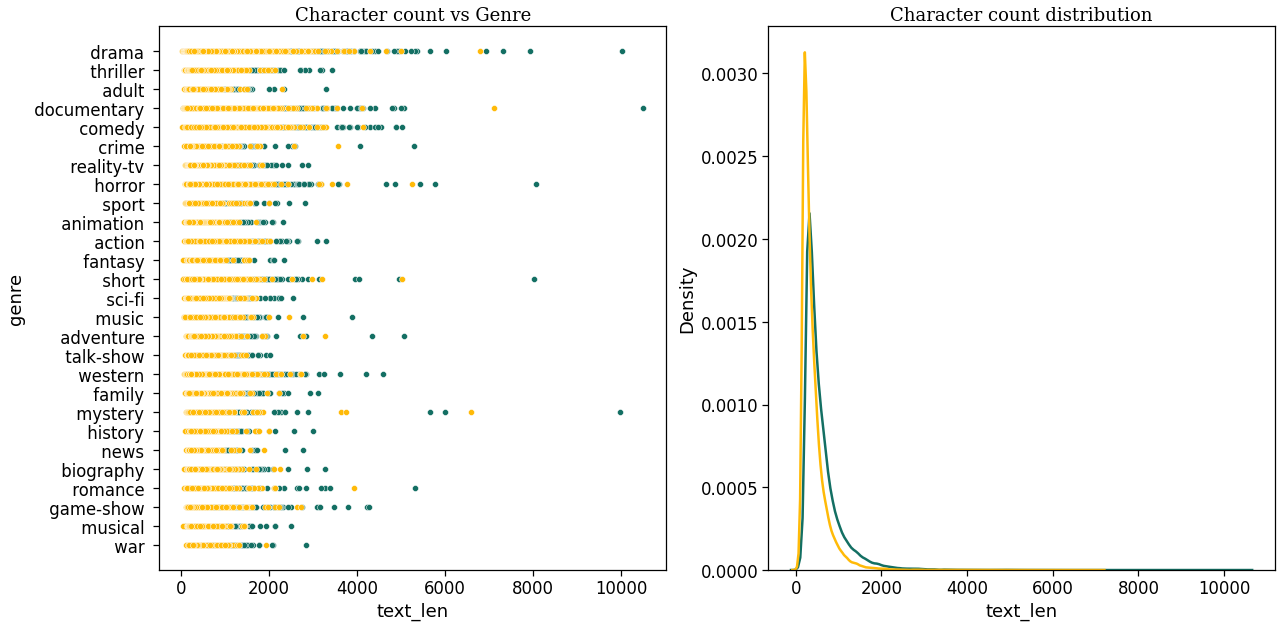

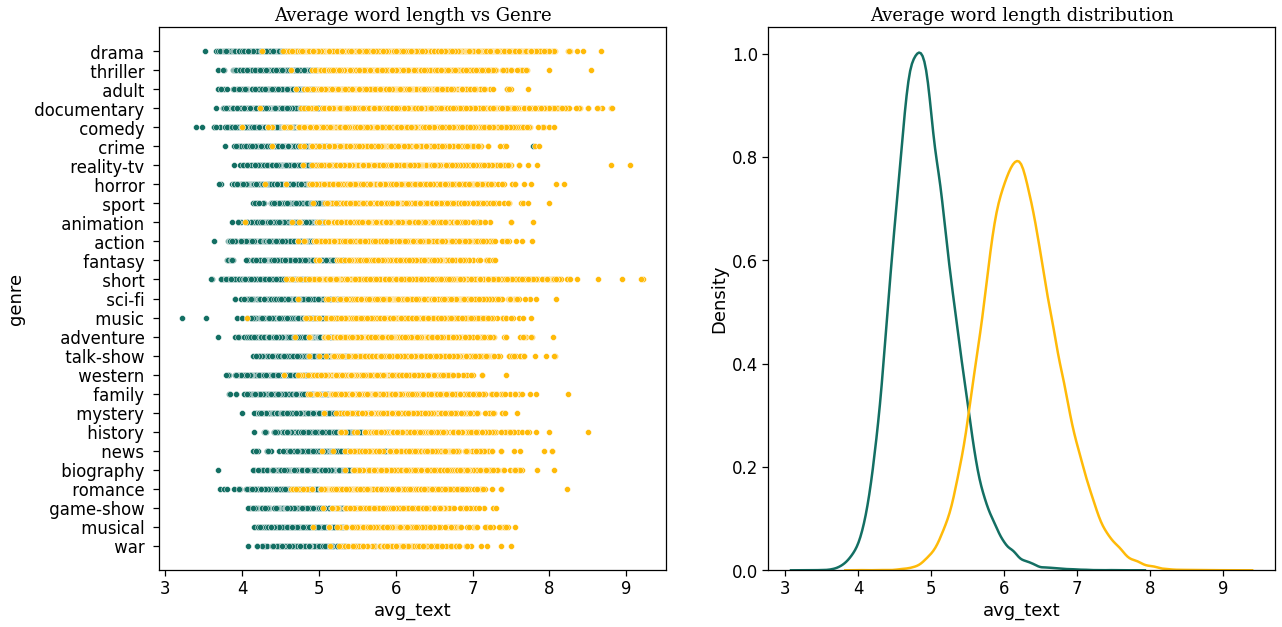

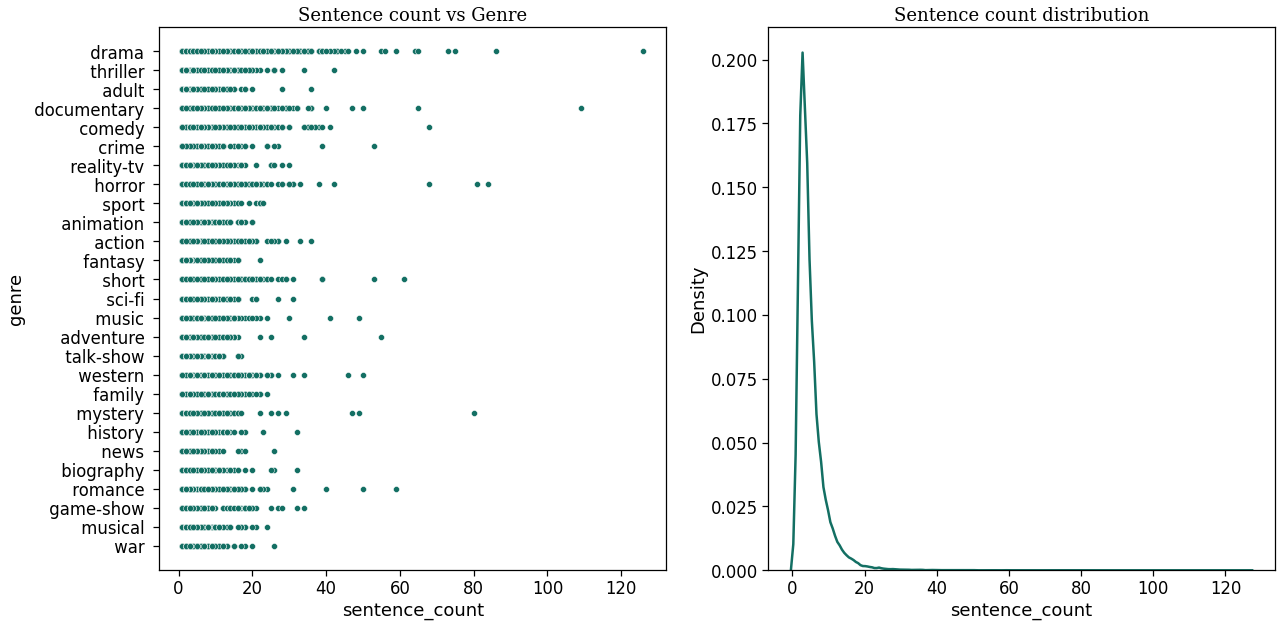

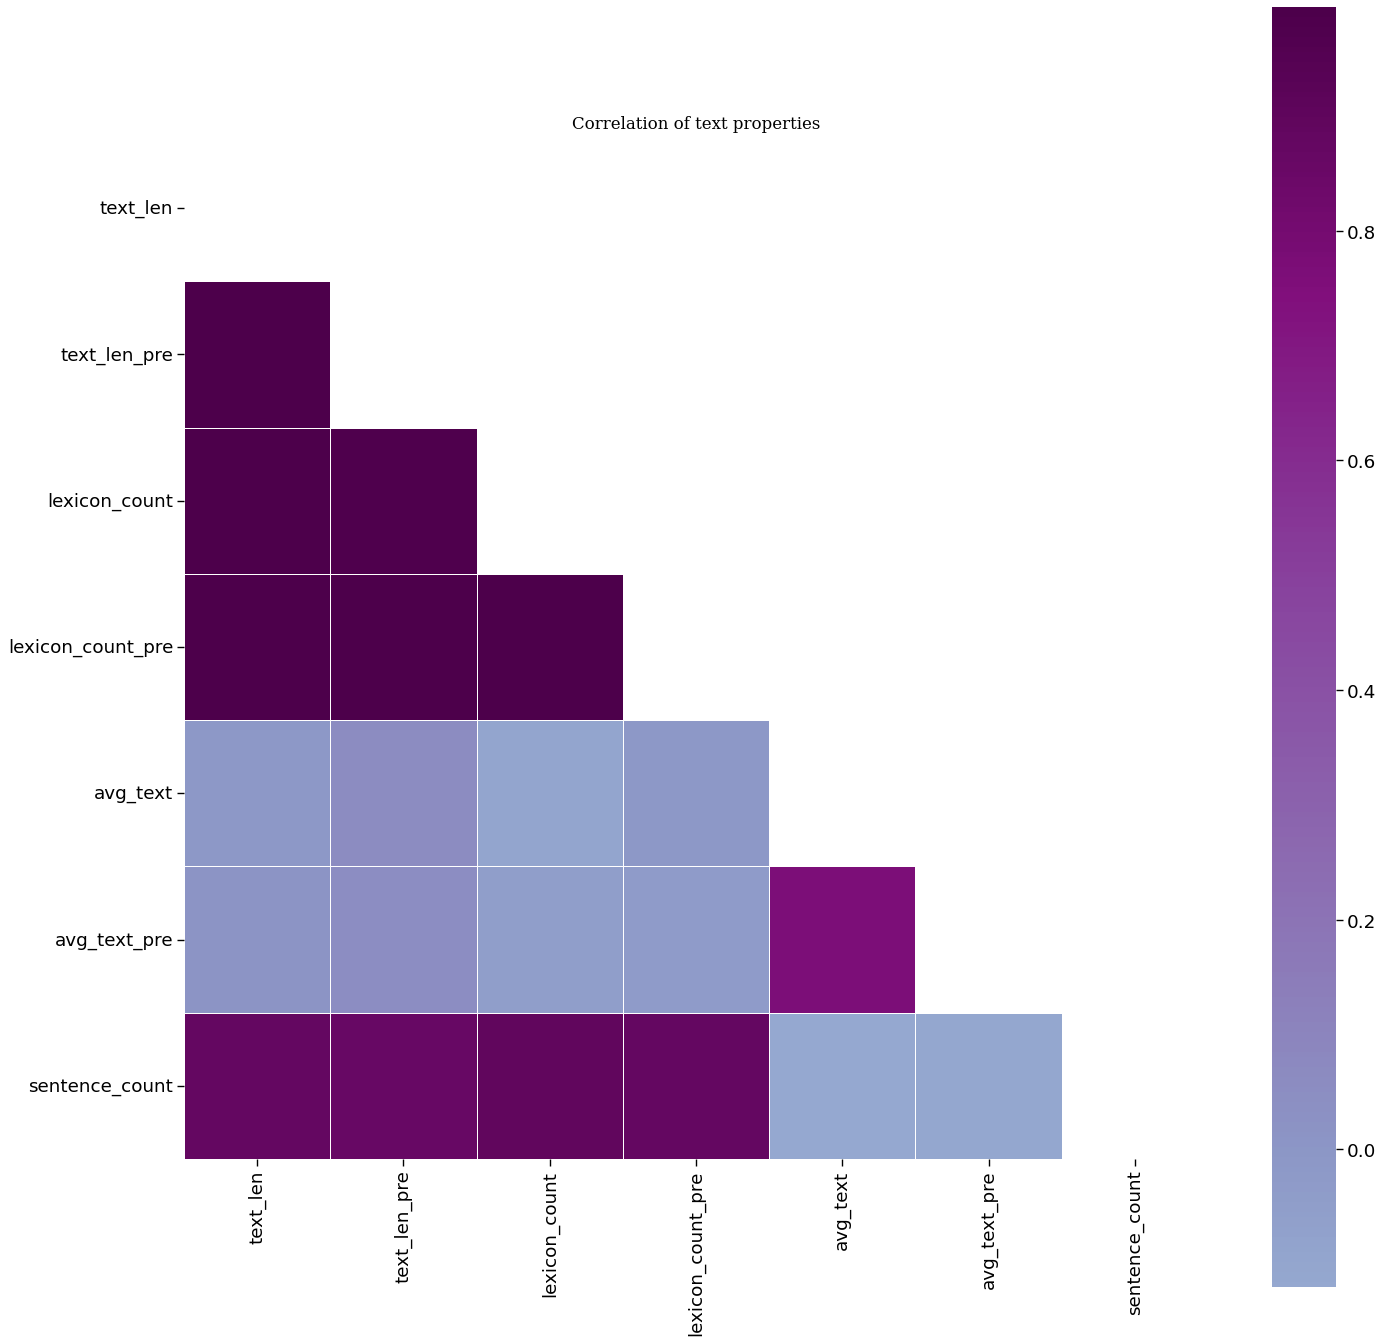

In [26]:
#EDA
text_props = en_training_dataset.copy()

def avg_word_len(df):
    df = df.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
    return df

text_len = en_training_dataset['description'].str.len()
text_len_pre = en_training_dataset['clean_description'].str.len()
avg_text = avg_word_len(en_training_dataset['description'])
avg_text_pre = avg_word_len(en_training_dataset['clean_description'])
lexicon_count = []
lexicon_count_pre = []
sentence_count = []
for i in range(len(en_training_dataset)):
    lc = textstat.lexicon_count(en_training_dataset['description'].iloc[i])
    lcp = textstat.lexicon_count(en_training_dataset['clean_description'].iloc[i])
    sc = textstat.sentence_count(en_training_dataset['description'].iloc[i])
    lexicon_count.append(lc)
    lexicon_count_pre.append(lcp)
    sentence_count.append(sc)
    
text_props['text_len'] = text_len
text_props['text_len_pre'] = text_len_pre
text_props['lexicon_count'] = lexicon_count
text_props['lexicon_count_pre'] = lexicon_count_pre
text_props['avg_text'] = avg_text
text_props['avg_text_pre'] = avg_text_pre
text_props['sentence_count'] = sentence_count

def plot_distribution(col1,col2,title1,title2):
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    sns.kdeplot(data=text_props, x=col1,color=palette[2],label="Description",ax=ax[1])
    sns.kdeplot(data=text_props, x=col2,color=palette[4],label="Cleaned Description",ax=ax[1])
    ax[1].set_title(title1,font="Serif")

    sns.scatterplot(data=text_props,x=col1,y='genre',color= palette[2],ax=ax[0],markers='.')
    sns.scatterplot(data=text_props,x=col2,y='genre',color= palette[4],ax=ax[0],markers='.')
    ax[0].set_title(title2,font="Serif")

    plt.show()

custom_lines = [Line2D([0], [0], color=palette[2], lw=4),
                Line2D([0], [0], color=palette[4], lw=4)]

plt.figure(figsize=(20, 1))
legend = plt.legend(custom_lines, ['Description', 'Cleaned Description'],loc="center")
plt.setp(legend.texts, family='Serif')
plt.axis('off')
plt.show()

plot_distribution("lexicon_count","lexicon_count_pre","Word count distribution","Word count vs Genre")
plot_distribution("text_len","text_len_pre","Character count distribution","Character count vs Genre")
plot_distribution("avg_text","avg_text_pre", "Average word length distribution","Average word length vs Genre")

fig, ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(data=text_props, x=sentence_count,color=palette[2],label="text",ax=ax[1])
ax[1].set_title("Sentence count distribution",font="Serif")
ax[1].set_xlabel("sentence_count")
sns.scatterplot(data=text_props,x='sentence_count',y='genre',color= palette[2],ax=ax[0],markers='.')
ax[0].set_title("Sentence count vs Genre",font="Serif")
plt.show()

num_cols = ['text_len','text_len_pre','lexicon_count','lexicon_count_pre','avg_text','avg_text_pre','sentence_count','genre']
corr = text_props[num_cols].corr()

fig = plt.figure(figsize=(20,20),dpi=80)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='BuPu', robust=True, center=0,
            square=True, linewidths=.5)
fig.tight_layout(pad=10.0)
plt.title('Correlation of text properties', fontsize=15,font="Serif")
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.6)
plt.show()


In [27]:
en_training_dataset.head()

title       genre  \
id                                                   
1        Oscar et la dame rose (2009)       drama    
2                        Cupid (1997)    thriller    
3    Young, Wild and Wonderful (1980)       adult    
4               The Secret Sin (1915)       drama    
5              The Unrecovered (2007)       drama    

                                          description language  \
id                                                               
1    Listening in to a conversation between his do...       en   
2    A brother and sister with a past incestuous r...       en   
3    As the bus empties the students for their fie...       en   
4    To help their unemployed father make ends mee...       en   
5    The film's title refers not only to the un-re...       en   

                                    clean_description  length  length_cleaning  
id                                                                              
1   listening conversation doctor parents year old...     546              383  
2   brother sister past incestuous relationship cu...     184              119  
3   bus empties students field trip museum natural...     650              402  
4   help unemployed father make ends meet edith tw...    1082              745  
5   films title refers recovered bodies ground zer...     625              402

In [28]:
#Using labelencoder to transform the categorical target genre values to numerical for model building as only numerical values are expected
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
en_training_dataset['encoded_genre'] = le.fit_transform(en_training_dataset["genre"].values)
en_testing_dataset['encoded_genre'] = le.transform(en_testing_dataset["genre"].values)

In [29]:
#Keep only relevant columns
en_training = en_training_dataset.loc[:,['clean_description', 'genre','encoded_genre']]
en_testing = en_testing_dataset.loc[:,['clean_description','genre', 'encoded_genre']]

In [30]:
en_training.head()

clean_description       genre  \
id                                                                  
1   listening conversation doctor parents year old...      drama    
2   brother sister past incestuous relationship cu...   thriller    
3   bus empties students field trip museum natural...      adult    
4   help unemployed father make ends meet edith tw...      drama    
5   films title refers recovered bodies ground zer...      drama    

    encoded_genre  
id                 
1               8  
2              24  
3               1  
4               8  
5               8

In [ ]:
#Code to sample the reduced subset of data to have equal proportions of the genres as present in the original dataset

import math
def reduce_samples(total_samples, counts):
    approximate_each_category = math.ceil(counts.count()/total_samples)
    selected_count = 0
    sorted_dict = convert_to_sorted_dict(counts)
    print(type(sorted_dict))
    new_dict = dict.fromkeys(sorted_dict.keys(),0)
    while (selected_count <= total_samples):
        keys_to_remove = []
        for k, v in sorted_dict.items():
            if sorted_dict[k] <= approximate_each_category:
                new_dict[k] += sorted_dict[k]
                selected_count += new_dict[k]
                keys_to_remove.append(k)
            else:
                new_dict[k] += approximate_each_category
                selected_count += approximate_each_category
                sorted_dict[k] = sorted_dict[k] - approximate_each_category
        for key in keys_to_remove:
            sorted_dict.pop(key)
        approximate_each_category = math.ceil((total_samples - selected_count)/len(sorted_dict))
        print("Approx Remaining: ", approximate_each_category)
    return new_dict

def unsample_dataframe(input_df, reduced_sample_counts):
    df = pd.DataFrame()
    for k, v in reduced_sample_counts.items():
        new_df = input_df.loc[(input_df['Genre'] == k)].iloc[:v]
        df = pd.concat([df, new_df])
    return df

def convert_to_sorted_dict(series):
    dictionary = series.to_dict()
    return dict(sorted(dictionary.items(), key=lambda item: item[1]))

In [ ]:
'''
Commented code to experiment with sampling the data before training the language models
'''
# counts = train_dataset['Genre'].value_counts()
# reduced_count= reduce_samples(10000, counts)
# training_dataframe = unsample_dataframe(train_dataset, reduced_count)

In [31]:
pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.5/250.5 kB 3.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 49.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 60.2 MB/s eta 0:00:0000:01:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=8ea36bb48ae1c35e71ab76eaaa9242edd4296d6b69daa3641cebde5ebcde6600
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=c9437caf1c4c9262b68c8e0a701690f1b1d86034493c03ef5e1aa83a7bab68ff
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9

In [32]:
#Reporting the accuracy metrics, namely, Precision, Recall, F1-score and accuracy
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

def recall_multiclass(labels, preds):
    return recall_score(labels, preds, average='macro')

def precision_multiclass(labels, preds):
    return precision_score(labels, preds, average='macro')

In [33]:
from simpletransformers.classification import ClassificationModel
results = []
#This block contains the actual code logic for fine-tuning pre-trained language models taken from HuggingFace for the specific purpose of classifying genres of movies. This block also deals with all the hyperparameter values and arguments expected by the method
warnings.filterwarnings("ignore")
def invoke_bert_model(train_df, test_df):
    samplesize = {1000: 300, 5000:1500, 10000:3000, 20000:6000, 50000:15000}
    for k,v in samplesize.items():
        
        updated_training_dataset = train_df.head(k)
        updated_testing_dataset = test_df.head(v)
        
        #update Epoch based on number of Trainig Samples
        if(k == 1000):
            epoch = 15
        elif(k == 5000):
            epoch = 4
        else:
            epoch = 2
        
        #Hyper Parameter Tuning
        model_args = {
            "reprocess_input_data": True,
            "overwrite_output_dir": True,
            "save_model_every_epoch": False,
            "save_eval_checkpoints": False,
            "max_seq_length": 512,
            "train_batch_size": 16,
            "num_train_epochs": epoch,
        }
        # Create a ClassificationModel
        model = ClassificationModel('bert', 'bert-base-uncased', num_labels=len(updated_training_dataset['genre']), args=model_args)
        warnings.filterwarnings("ignore")
        model.train_model(updated_training_dataset[['clean_description','encoded_genre']])
        warnings.filterwarnings("ignore")
        result, model_outputs, wrong_predictions = model.eval_model(updated_testing_dataset.head(int(0.3*len(train_dataset)))[['clean_description','encoded_genre']], f1=f1_multiclass, rec=recall_multiclass,prec = precision_multiclass, acc=accuracy_score)
        warnings.filterwarnings("ignore")
        results.append(result)
        
        #Prints the performance metrics computed in the above block
        print("Results for ",k, "training and ", v, "testing samples ", result)

In [ ]:
invoke_bert_model(en_training, en_testing)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Running Epoch 0 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 1 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 2 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 3 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 4 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 5 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 6 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 7 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 8 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 9 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 10 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 11 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 12 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 13 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

Running Epoch 14 of 15:   0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/38 [00:00<?, ?it/s]

Results for  1000 training and  300 testing samples 
{
    'mcc': 0.38711607903649564,
    'f1': 0.21647847285449143,
    'rec': 0.25147564927510485,
    'prec': 0.21621427742117397,
    'acc': 0.4866666666666667,
    'eval_loss': 2.369434431979531
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/313 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/313 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/313 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/188 [00:00<?, ?it/s]

Results for  5000 training and  1500 testing samples 
{
    'mcc': 0.4870868642051931,
    'f1': 0.19341921492412797,
    'rec': 0.20973633432887298,
    'prec': 0.1902591993353876,
    'acc': 0.5786666666666667,
    'eval_loss': 1.643035482853017
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/625 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/375 [00:00<?, ?it/s]

Results for  10000 training and  3000 testing samples 
{
    'mcc': 0.4731581247266078,
    'f1': 0.16115833969989846,
    'rec': 0.17075885590497022,
    'prec': 0.2042354597208206,
    'acc': 0.5696666666666667,
    'eval_loss': 1.5827374674479167
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/1250 [00:00<?, ?it/s]

In [ ]:
from simpletransformers.classification import ClassificationModel
results = []

warnings.filterwarnings("ignore")
def invoke_roberta_model(train_df, test_df):
    samplesize = {1000: 300, 5000:1500, 10000:3000, 20000:6000, 50000:15000}
    for k,v in samplesize.items():
        
        updated_training_dataset = train_df.head(k)
        updated_testing_dataset = test_df.head(v)
        
        if(k == 1000):
            epoch = 15
        elif(k == 5000):
            epoch = 4
        else:
            epoch = 2
        
    
        model_args = {
            "reprocess_input_data": True,
            "overwrite_output_dir": True,
            "save_model_every_epoch": False,
            "save_eval_checkpoints": False,
            "max_seq_length": 512,
            "train_batch_size": 16,
            "num_train_epochs": epoch,
        }
        # Create a ClassificationModel
        model = ClassificationModel('roberta', 'roberta-base', num_labels=len(updated_training_dataset['genre']), args=model_args)
        warnings.filterwarnings("ignore")
        model.train_model(updated_training_dataset[['clean_description','encoded_genre']])
        warnings.filterwarnings("ignore")
        result, model_outputs, wrong_predictions = model.eval_model(updated_testing_dataset.head(int(0.3*len(train_dataset)))[['clean_description','encoded_genre']], f1=f1_multiclass, rec=recall_multiclass,prec = precision_multiclass, acc=accuracy_score)
        warnings.filterwarnings("ignore")
        
        #Prints the performance metrics computed in the above block
        results.append(result)
        print("Results for ",k, "training and ", v, "testing samples ", result)

In [ ]:
invoke_roberta_model(en_training, en_testing)

In [ ]:
from simpletransformers.classification import ClassificationModel
results = []

warnings.filterwarnings("ignore")
def invoke_electra_model(train_df, test_df):
    samplesize = {1000: 300, 5000:1500, 10000:3000, 20000:6000, 50000:15000}
    for k,v in samplesize.items():
        
        updated_training_dataset = train_df.head(k)
        updated_testing_dataset = test_df.head(v)
        
        if(k == 1000):
            epoch = 15
        elif(k == 5000):
            epoch = 4
        else:
            epoch = 2
        
    
        model_args = {
            "reprocess_input_data": True,
            "overwrite_output_dir": True,
            "save_model_every_epoch": False,
            "save_eval_checkpoints": False,
            "max_seq_length": 512,
            "train_batch_size": 16,
            "num_train_epochs": epoch,
        }
        # Create a ClassificationModel
        model = ClassificationModel('electra', 'google/electra-base-generator', num_labels=len(updated_training_dataset['genre']), args=model_args)
        warnings.filterwarnings("ignore")
        model.train_model(updated_training_dataset[['clean_description','encoded_genre']])
        warnings.filterwarnings("ignore")
        result, model_outputs, wrong_predictions = model.eval_model(updated_testing_dataset.head(int(0.3*len(train_dataset)))[['clean_description','encoded_genre']], f1=f1_multiclass, rec=recall_multiclass,prec = precision_multiclass, acc=accuracy_score)
        warnings.filterwarnings("ignore")
        
        #Prints the performance metrics computed in the above block
        results.append(result)
        print("Results for ",k, "training and ", v, "testing samples ", result)

In [ ]:
invoke_electra_model(en_training, en_testing)